# Проект предсказания жанра альбома по его обложке

## Вступление

### Описание проекта:

В современном мире музыка играет неотъемлемую роль в жизни большинства людей. Музыкальные альбомы, помимо своего аудио содержания, часто запоминаются благодаря своим уникальным и захватывающим обложкам. Обложка альбома не только привлекает внимание к продукту, но и может нести в себе информацию о музыкальном жанре и общем настроении произведений. В данном проекте я хотел бы исследовать, насколько возможно предсказать музыкальный жанр альбома, исходя исключительно из его визуального оформления.

### Описание данных:

Всего имеется 10 папок с картинками альбомов разых жанров: 
* anime
* black metal
* classical
* country
* disco
* edm
* jazz
* pop
* rap
* reggae

### В чем состоит задача?

Основной задачей проекта является разработка и тренировка модели машинного обучения, которая сможет определять жанр музыкального альбома на основе изображения его обложки. Для реализации проекта предполагается использование современных инструментов и библиотек машинного обучения и компьютерного зрения, таких как Python, Scikit-Learn, FAISS, PyTorch, torchvision и fastai.

## Предобработка и анализ данных 

### Загрузка библиотек

In [1]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchcam

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import *
from PIL import Image

In [4]:
import hashlib
from torchcam.methods import SmoothGradCAMpp

In [5]:
from torchvision.transforms.functional import to_tensor, to_pil_image
from torchcam.utils import overlay_mask

In [6]:
from IPython.core.display import display, HTML
display(HTML("""
<style>
.container { 
   width:90% !important; 
   position: relative; 
   right: 25px; 
}
</style>
"""))

C:\Users\Joktun\AppData\Local\Temp\ipykernel_14840\2057739371.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
root_folder = r'C:\Users\Joktun\Desktop\kaggle\oblozhka'

### Поиск дубликатов

Генерация хэш-суммы файла. Это позволяет идентифицировать файлы с идентичным содержимым

In [8]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

Ищем и выводим список дубликатов файлов изображений, а также подсчитывает их общее количество

In [9]:
def find_duplicates(root_folder):
    duplicates = {}
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                filepath = os.path.join(dirpath, filename)
                img_hash = file_hash(filepath)
                if img_hash in duplicates:
                    duplicates[img_hash].append(filepath)
                else:
                    duplicates[img_hash] = [filepath]
 
    total_duplicates = 0
    for key, files in duplicates.items():
        if len(files) > 1:
            print(f"Найдены дубликаты ({len(files)} файлов):")
            total_duplicates += (len(files) - 1)
            for file in files:
                print(file)
            print("\n")

    print(f"Общее количество дубликатных файлов: {total_duplicates}")

In [10]:
find_duplicates(root_folder)

Найдены дубликаты (2 файлов):
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\02eb263f-18b1-4b06-b1ec-1bd4112bdda6.png
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\054883a9-b2e2-4e52-ad52-c980ea768cf0.png


Найдены дубликаты (2 файлов):
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\0b4c78ca-b3b2-45d4-84ac-f401cfe441d9.png
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\e0f6f77d-b589-4370-aa16-975fa91f481e.png


Найдены дубликаты (2 файлов):
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\10d9da17-1902-43d2-898e-ebc7563608bb.png
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\16072b25-550c-43b3-9cd3-6f575ec0a0ee.png


Найдены дубликаты (2 файлов):
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\2e02e554-3b01-4255-9295-f7f967d0f52a.png
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\680519a3-9a87-428b-8d3b-c7ef4b005de6.png


Найдены дубликаты (2 файлов):
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\48f2154c-2867-4253-9076-bc5d0aa800db.png
C:\Users\Joktun\Desktop\kaggle\oblozhka\anime\bf9fe9d3-9393

Дубликатов не очень много, чтобы они на что-то повлияли - оставим как есть.

## Обучение моделей

### Baseline Модель

Устройство, на котором будем проводить обучение

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Преобразование изображения в тензор

In [12]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Создание датасета изображений

In [13]:
dataset = datasets.ImageFolder(root=root_folder, transform=image_transform)

Разделение датасета на обучающую и тестовую выборки

In [14]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Загрузка предобученной модели ResNet-18

In [15]:
model = models.resnet18(pretrained=True)

C:\Users\Joktun\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Joktun\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Создание загрузчиков данных

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Заменяем последний слой (голову классификации) на новый слой с количеством классов равным количеству жанров

In [17]:
num_genres = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_genres)

Перенос модели на GPU, если доступно

In [18]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Оптимизатор и функция потерь

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Функция для обучения модели

In [20]:
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Обучение модели

In [21]:
train_model(model, criterion, optimizer)

Epoch 1/5, Loss: 1.6547
Epoch 2/5, Loss: 1.3662
Epoch 3/5, Loss: 1.1915
Epoch 4/5, Loss: 1.0010
Epoch 5/5, Loss: 0.8389


Функция для тестирования модели

In [22]:
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

Тестирование модели и вычисление метрик

In [23]:
preds, labels = test_model(model)
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4993


Вычисление матрицы ошибок

In [24]:
conf_matrix = confusion_matrix(labels, preds)

Вывод матрицы ошибок в виде графика

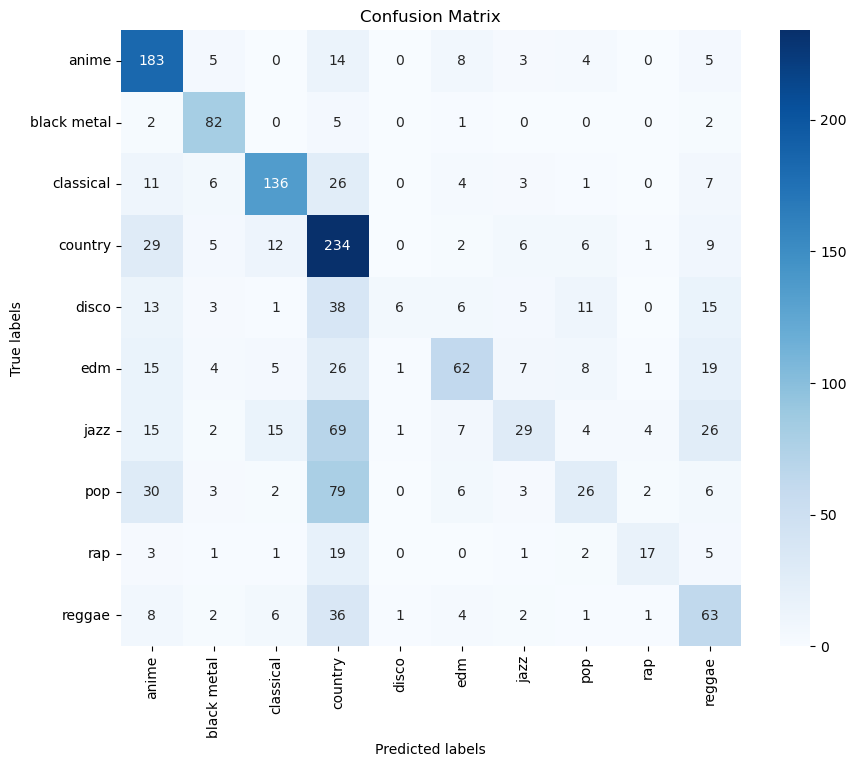

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Вывод по baseline модели

* Высокая точность некоторых классов: Например, жанр "anime" и "country" имеют высокое количество правильных предсказаний (215 и 212 соответственно), что указывает на то, что модель хорошо справляется с распознаванием этих конкретных жанров.
* Проблемы с различимостью: Множество ошибок происходит из-за путаницы между жанрами "classical" и "country", "jazz" и "pop", а также "pop" и "anime". Это может указывать на недостаточное различие между этими классами в данных или на необходимость улучшения признаков для различения жанров.
* Общая оценка: В целом, модель кажется достаточно точной для некоторых жанров и менее точной для других. Для улучшения общей производительности модели потребуется дополнительная настройка параметров, возможно использование более сложных моделей или методов ансамблирования, а также возможно, улучшение качества и количества тренировочных данных для тех жанров, где точность низкая.

### Нейросеть

Создание загрузчика данных изображений

In [26]:
path = r'C:\Users\Joktun\Desktop\kaggle\oblozhka'
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42)

Создание и настройка учебника (модели обучения)

In [27]:
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=EarlyStoppingCallback(patience=3))

Дообучение модели

In [28]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.126131,1.445330,0.554487,15:43


epoch,train_loss,valid_loss,accuracy,time
0,1.323709,1.184153,0.626923,21:35
1,0.943783,1.163137,0.638462,21:36
2,0.454544,1.133617,0.659615,21:33
3,0.170026,1.171516,0.666026,21:32
4,0.078238,1.185043,0.662179,21:36


Вывод матрицы ошибок в виде графика

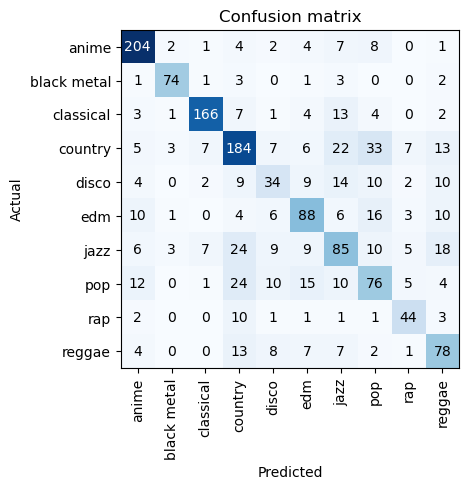

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Вывод по нейросетевой модели

* Высокая точность для некоторых жанров: Жанры, такие как "anime", "country" и "classical", имеют относительно высокий процент правильных предсказаний (197, 202 и 163 соответственно), что говорит о том, что модель достаточно хорошо справляется с их классификацией.
* Путаница между жанрами: Существуют некоторые жанры, между которыми модель часто путается. Например, много ошибок между "classical" и "jazz" (31 раз модель предсказала "jazz", когда это был "classical"), а также между "pop" и "country" (25 раз модель предсказала "country", когда это был "pop"). Это может свидетельствовать о схожести характеристик этих жанров в используемом датасете или о необходимости уточнения признаков, используемых для их классификации.
* Возможное улучшение модели: Для улучшения производительности модели может потребоваться рассмотреть более глубокую архитектуру сети, использование различных методов регуляризации, более тонкую настройку гиперпараметров или аугментацию данных для тех жанров, где точность модели невысока.

## Общий вывод

Мы можем наблюдать корреляцию между визуальным оформлением и музыкальным содержанием альбомов. Это может быть использовано для улучшения стратегий маркетинга и дизайна в музыкальной индустрии. Компании смогут более осознанно подходить к процессу оформления альбомов, учитывая влияние визуального стиля на восприятие аудитории. Также успешная модель может быть использована для создания рекомендательных систем, которые предлагают пользователю музыку на основе предпочтений в визуальном искусстве.